In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import statsmodels.stats.multitest as smm
from scipy import stats
import seaborn as sns

from Bio import Seq

pd.options.mode.chained_assignment = None

#makes viewing pandas tables better
pd.set_option('display.max_colwidth', 0)

Change the following parameters to your output directory (where you want output files to be written), your metafile, and TNseq output. 

If these files aren't in the same directory as this notebook, you need use the full path. For example, the full path of 'barseq_output' would be '/usr2/people/clairedubin/barseq/barseq_output'

Also change the control and experimental temperatures if needed.

In [2]:
#where the BarSeq FASTQs are
FASTQ_directory = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C'


## Barseq metafile

You'll need to create your own metafile - easiest way is edit in Excel. A sample metafile is located at: /usr2/people/clairedubin/barseq/Kluyv_BarSeq_metadata.txt

    Fastq: path to barseq FASTQ for each competition
    SampleName: unique name for each competition, MUST include ctrl_temp or exp_temp as specified above
    DualIndex: index from sequencing (in read name lines of FASTQ and the sequencing info file that Adam sends)
    
    UsePrecounted: True if you've already run the Barseq counting script on a competition, False otherwise
    
    poolfile: path to Tnseq output file, should be the same for each competition
    output_dir: path to output directory
    minRandom: number of bases between start of read and DualIndex, usually in sequence of 1,2,3,4,1,2,3,4 for each sample
    maxRandom: same as minRandom
    
    BeforeBarcode: sequence preceding all barcodes
    AfterBarcode: sequence following all barcodes
    BarcodeLengths: lengths of barcodes to search for, with expected length of barcode first

    

In [3]:
!ls {FASTQ_directory}/*fastq

/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB011_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB012_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB013_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB014_S1_L001_R1_001.fastq


In [4]:
#format: sample_name, fastq_path, dual_index, offset
#add or delete more lines as needed

sample_info = [('KFRB011_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB011_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('KFRB012_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB012_S1_L001_R1_001.fastq', 'CGATGT', '2'), 
               ('KFRB013_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB013_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('KFRB014_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB014_S1_L001_R1_001.fastq', 'CGATGT', '2'),
               ]

In [5]:
!head /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_Feb_2024/KFRB001_S1_L001_R1_001.fastq

@M02248:14:000000000-DNH2T:1:1102:15643:1331 1:N:0:NTCACG
AGCACTAGTCGACCTGCAGCGTACGTATATGCGGTCCATGTTAGTAGAGACCTCGTGGACATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATCACGATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAA
+
CCCCCFFFFFCBGGGGGGGGGEEFEGHHHHHHGGGGGHHHHHHHHHHHHHHGHHGHHGGHHHHGHHHHHGEGGGHHGHHHGHHHGFHHHHHHHHHGHHHHHGFEHFHHHGGHHHHGGGHGHHHHHHHCFGHHGGGG@A--
@M02248:14:000000000-DNH2T:1:1102:16005:1334 1:N:0:NTCACG
TTATTTCCTAGACAAATTAGAGCCAATACCATCAGCTTTACCGTCTTTCCAGAAATTGTTCCAAGTATCGGCAACAGCTTTATCAATACCATGAAAAATATCAACCACACCAGAAGCAGCATCAGTGACGACACTTGGAA
+
AAAAAFFFDFFFGGGG1BFGF1FFCGHHFFGFHHBGDHHGDGC0BAFDDGHFFG1FFFADEGHHHAEFFE/E/EFF0FFGGFHHHH1GFGHGFBGGHHHHDHFFBGCFFAEAGHHFFH0FGHHHBGFGH/FGGCFHGHFG
@M02248:14:000000000-DNH2T:1:1102:15502:1334 1:N:0:NTCACG
GGCACTAGTCGACCTGCAGCGTACGACGGTGCTCCAAGTGTGGGCAGAGACCTCGTGGACATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACATCACGATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAATAT


In [6]:
#if there are any samples where you already counted barcodes, add the sample names here
precounted_samples = []

In [7]:
#these variables should be the same for each replicate

metafile_name = 'BarSeq_metafile_04_11_2024_mainlocation.txt'
logfile_name = 'BarSeq_counting_04_11_2024_mainlocation.log'
poolfile = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNseq_single_position_nMainLocation_annotated_file.csv'
output_dir = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C'
before_barcode = 'GTCGACCTGCAGCGTACG' #bottom strand sequence was used
#before_barcode = 'GATGTCCACGAGGTCTCT' what was there before 
after_barcode =  'AGAGACCTCGTGGACATC' #bottom strand sequence was used
#after_barcode = 'CGTACGCTGCAGGTCGAC'  what was there before /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNseq_single_position_nMainLocation_annotated_file.csv
barcode_lengths = '20,19,18,21'

In [8]:
metafile_columns = ['FileIndex','SampleName', 'Fastq', 'DualIndex', 'Poolfile', 'OutputDir', 'minRandom', 'maxRandom',
                   'BeforeBarcode', 'AfterBarcode', 'BarcodeLengths', 'UsePrecounted']

with open(metafile_name, 'w') as f:
    
    #write column names
    f.write('\t'.join(metafile_columns)+'\n')
    
    #write a line for each pool
    for sample_name, fastq, dual_index, offset in sample_info:
        
        #DUAL INDECES ARE BACKWARDS FROM WHAT THE FLOWCELL OUTPUT SAYS
        to_write = '\t'.join([sample_name, sample_name, fastq, dual_index[::-1], poolfile, output_dir, offset, offset,
                             before_barcode, after_barcode, barcode_lengths, 'False'])
        f.write(to_write+'\n')
        
    for precounted_sample_name in precounted_samples:
        
        to_write = '\t'.join([sample_name, sample_name, fastq, dual_index, poolfile, output_dir, offset, offset,
                             before_barcode, after_barcode, barcode_lengths, 'True'])




### Check metafile

In [9]:
pd.read_csv(metafile_name, sep='\t')

,FileIndex,SampleName,Fastq,DualIndex,Poolfile,OutputDir,minRandom,maxRandom,BeforeBarcode,AfterBarcode,BarcodeLengths,UsePrecounted
0,KFRB011_1,KFRB011_1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB011_S1_L001_R1_001.fastq,GCACTA,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNseq_single_position_nMainLocation_annotated_file.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C,1,1,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
1,KFRB012_1,KFRB012_1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB012_S1_L001_R1_001.fastq,TGTAGC,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNseq_single_position_nMainLocation_annotated_file.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C,2,2,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
2,KFRB013_1,KFRB013_1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB013_S1_L001_R1_001.fastq,GCACTA,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNseq_single_position_nMainLocation_annotated_file.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C,1,1,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
3,KFRB014_1,KFRB014_1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/BarSeq_FASTQs_April_2024_37_vs_50C/KFRB014_S1_L001_R1_001.fastq,TGTAGC,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNseq_single_position_nMainLocation_annotated_file.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C,2,2,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False


## Barseq counting

Might take a few hours!

In [10]:
!python3 /usr2/people/clairedubin/barseq/latest_pipeline/RBseq_Count_BarCodes_v2.py -m {metafile_name} -l {logfile_name}

2024-04-11 12:29:42 RBseq_Count_BarCodes.py
2024-04-11 12:29:42 Version: 1.1.4
2024-04-11 12:29:42 Release Date: July 16, 2020
2024-04-11 12:29:42 Options passed:  metafile:BarSeq_metafile_04_11_2024_mainlocation.txt  logFile:BarSeq_counting_04_11_2024_mainlocation.log  minQual:10  matchBefore:6  matchAfter:6  quietMode:False 
2024-04-11 12:29:42 Logging status updates in BarSeq_counting_04_11_2024_mainlocation.log
2024-04-11 12:29:42 Loading TnSeq library metadata from BarSeq_metafile_04_11_2024_mainlocation.txt
2024-04-11 12:29:42 Setting output directory as: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C (from first line of metadata file)
2024-04-11 12:29:42 Loading mapped barcodes in mutant pool from: /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNseq_single_position_nMainLocation_annotated_file.csv (from first line of metadata file)
2024-04-

2024-04-11 12:30:09   Total barcodes seen (incudes sequencing errors): 32077
2024-04-11 12:30:09   Matching barcodes to poolfile
2024-04-11 12:30:09     Number of barcodes from poolfile seen: 2083
2024-04-11 12:30:09     Reads with barcodes from poolfile: 420621
2024-04-11 12:30:09   Most abundant barcode: ACGGTGTTCCAAGTGTGGGC seen 136151 times.
2024-04-11 12:30:09   Number of reads that differ from this barcode by one base pair (likely sequencing errors):4961
2024-04-11 12:30:09   Estimated sequencing error rate for barcodes: 3.5%
2024-04-11 12:30:09   Barcodes seen once (highly inflated by sequencing errors): 22599
2024-04-11 12:30:09   Barcodes seen twice (slightly inflated by sequencing errors): 2517
2024-04-11 12:30:09   Barcodes seen three times or more: 6961
2024-04-11 12:30:09   Chao estimate of population size (ones^2/2*twos): 100000
2024-04-11 12:30:09 ---------------------
2024-04-11 12:30:09 Saving summary statistics for fastqs to: /usr2/people/shollyt22/shollyt22/TnSeq_Bar

### To convert the poolcount file from txt to csv and not to be separated by tab

In [11]:
import csv

def txt_to_csv(input_file, output_file):
    with open(input_file, 'r') as txt_file:
        with open(output_file, 'w', newline='') as csv_file:
            txt_reader = csv.reader(txt_file, delimiter='\t')
            csv_writer = csv.writer(csv_file)

            for row in txt_reader:
                csv_writer.writerow(row)

if __name__ == "__main__":
    input_txt_file = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/poolCount.txt"  # Replace with the path to your tab-separated TXT file
    output_csv_file = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/poolCount_kris_37_vs_50C.csv"  # Replace with the desired path for the CSV output

    txt_to_csv(input_txt_file, output_csv_file)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

### for fitness at 37 oC

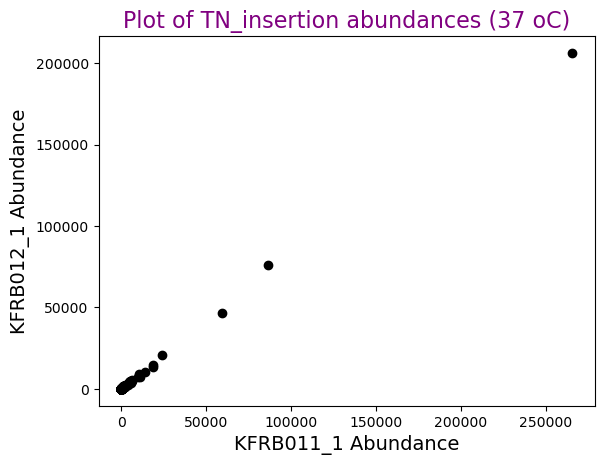

In [12]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB011_1'
y_column = 'KFRB012_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB011_1 Abundance', fontsize=14)
plt.ylabel('KFRB012_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances (37 oC)', fontsize=16, color='purple')
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_kris_02_29_2024_37oC_mainLoc.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB011_1'
y_column = 'KFRB012_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB011_1 Abundance', fontsize=14)
plt.ylabel('KFRB012_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances (37 oC)', fontsize=16, color='purple')

# Adjust the x and y-axis scale ranges
plt.xlim(0, 15000)  # Adjust the range for the x-axis
plt.ylim(0, 15000)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)

#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_kris_02_29_2024_37oC_1a_mainloc.png", dpi=600, bbox_inches='tight')
plt.show()


### for fitness at 50 oC

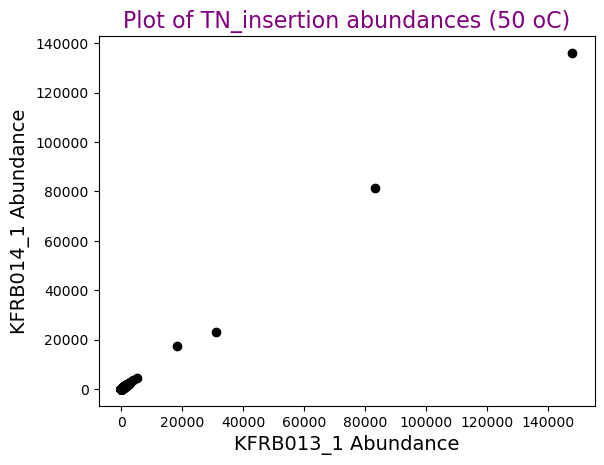

In [13]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB013_1'
y_column = 'KFRB014_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB013_1 Abundance', fontsize=14)
plt.ylabel('KFRB014_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances (50 oC)', fontsize=16, color='purple')
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_kris_02_29_2024_45oC_mainLoc.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB013_1'
y_column = 'KFRB014_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB003_1 Abundance', fontsize=14)
plt.ylabel('KFRB004_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances (50 oC)', fontsize=16, color='purple')

# Adjust the x and y-axis scale ranges
plt.xlim(0, 15000)  # Adjust the range for the x-axis
plt.ylim(0, 15000)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)

#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_kris_02_29_2024_45oC_1a_mainloc.png", dpi=600, bbox_inches='tight')
plt.show()


## to normalize the Barseq pool count file based on the number of reads obtained

#### normalization based on individual sample

### this is the normalization that worked with the right result

In [14]:
import pandas as pd

# Load the count file into a DataFrame
normalized_count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/poolCount_kris_37_vs_50C.csv'
df.to_csv(normalized_count_file_path, index=False)

# Calculate the total counts for each replicate
df['Total_Count_KFRB011_1'] = df['KFRB011_1'].sum()
df['Total_Count_KFRB012_1'] = df['KFRB012_1'].sum()
df['Total_Count_KFRB013_1'] = df['KFRB013_1'].sum()
df['Total_Count_KFRB014_1'] = df['KFRB014_1'].sum()


# Normalize counts for each replicate by dividing by its own Total_Count
df['Normalized_KFRB011_1'] = (df['KFRB011_1'] / df['Total_Count_KFRB011_1'])
df['Normalized_KFRB012_1'] = (df['KFRB012_1'] / df['Total_Count_KFRB012_1'])
df['Normalized_KFRB013_1'] = (df['KFRB013_1'] / df['Total_Count_KFRB013_1'])
df['Normalized_KFRB014_1'] = (df['KFRB014_1'] / df['Total_Count_KFRB014_1'])



# Save the normalized count file
normalized_count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/normalized_barseq_pool_counts_kris_37_50C_with_mainloc.csv'
df.to_csv(normalized_count_file_path, index=False)

##### To make the fitness abundance again using the normalized values

In [15]:
import pandas as pd

# Load the CSV file
csv_file_path = r'/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/normalized_barseq_pool_counts_kris_37_50C_with_mainloc.csv'
df = pd.read_csv(csv_file_path)

# Save the DataFrame to a text file (txt)
txt_file_path = r'/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/normalized_barseq_pool_counts_kris_37_50C_with_mainloc.txt'
df.to_csv(txt_file_path, sep='\t', index=False)


### Fitness plot with normalized value at 37 oC

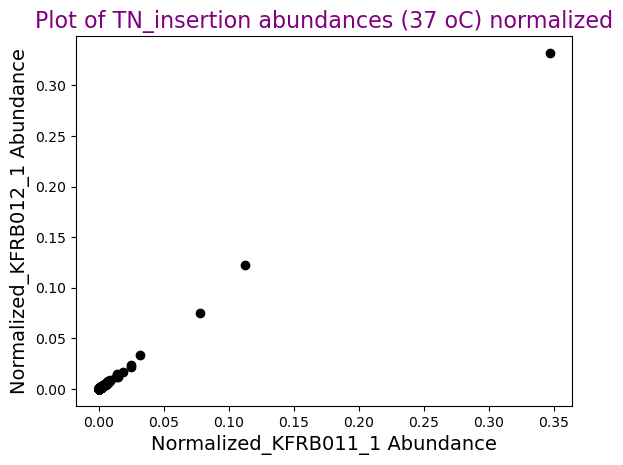

In [16]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/normalized_barseq_pool_counts_kris_37_50C_with_mainloc.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'Normalized_KFRB011_1'
y_column = 'Normalized_KFRB012_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('Normalized_KFRB011_1 Abundance', fontsize=14)
plt.ylabel('Normalized_KFRB012_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances (37 oC) normalized', fontsize=16, color='purple')
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_02_29_2024_37oC_Normalized_with_mainloc.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/normalized_barseq_pool_counts_kris_37_50C_with_mainloc.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'Normalized_KFRB011_1'
y_column = 'Normalized_KFRB012_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('Normalized_KFRB011_1 Abundance', fontsize=14)
plt.ylabel('Normalized_KFRB012_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances (37 oC) normalized', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 0.01)  # Adjust the range for the x-axis
plt.ylim(0, 0.01)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_02_29_2024_37oC_kris_Normalized_1_with_mainloc.png", dpi=600, bbox_inches='tight')
plt.show()

### Fitness plot with normalized value at 50 oC

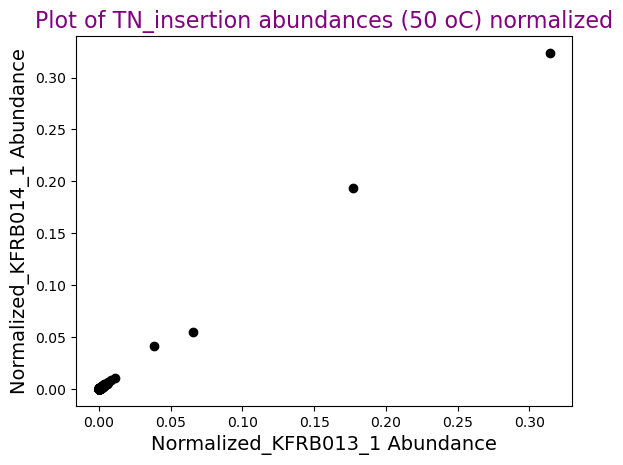

In [17]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/normalized_barseq_pool_counts_kris_37_50C_with_mainloc.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'Normalized_KFRB013_1'
y_column = 'Normalized_KFRB014_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('Normalized_KFRB013_1 Abundance', fontsize=14)
plt.ylabel('Normalized_KFRB014_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances (50 oC) normalized', fontsize=16, color='purple')
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_02_29_2024_45oC_Normalized_with_mainloc.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/normalized_barseq_pool_counts_kris_37_50C_with_mainloc.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'Normalized_KFRB013_1'
y_column = 'Normalized_KFRB014_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('Normalized_KFRB013_1 Abundance', fontsize=14)
plt.ylabel('Normalized_KFRB014_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances (50 oC) normalized', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 0.01)  # Adjust the range for the x-axis
plt.ylim(0, 0.01)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_02_29_2024_45oC_kris_Normalized_1_with_mainloc.png", dpi=600, bbox_inches='tight')
plt.show()

### To convert the filtered poolcount file from txt to csv and not to be separated by tab

In [18]:
import csv

def txt_to_csv(input_file, output_file):
    with open(input_file, 'r') as txt_file:
        with open(output_file, 'w', newline='') as csv_file:
            txt_reader = csv.reader(txt_file, delimiter='\t')
            csv_writer = csv.writer(csv_file)

            for row in txt_reader:
                csv_writer.writerow(row)

if __name__ == "__main__":
    input_txt_file = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/poolCount_kris_37_vs_50C_high_reads_filtered.txt"  # Replace with the path to your tab-separated TXT file
    output_csv_file = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/poolCount_kris_37_vs_50C_high_reads_filtered.csv"  # Replace with the desired path for the CSV output

    txt_to_csv(input_txt_file, output_csv_file)


#### to normalize the filtered poolcount file

In [20]:
import pandas as pd

# Load the count file into a DataFrame
count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/poolCount_kris_37_vs_50C_high_reads_filtered.csv'
df = pd.read_csv(count_file_path)

# Calculate the total counts for each replicate
df['Total_Count_KFRB011_1'] = df['KFRB011_1'].sum()
df['Total_Count_KFRB012_1'] = df['KFRB012_1'].sum()
df['Total_Count_KFRB013_1'] = df['KFRB013_1'].sum()
df['Total_Count_KFRB014_1'] = df['KFRB014_1'].sum()


# Normalize counts for each replicate by dividing by its own Total_Count
df['Normalized_KFRB011_1'] = (df['KFRB011_1'] / df['Total_Count_KFRB011_1'])
df['Normalized_KFRB012_1'] = (df['KFRB012_1'] / df['Total_Count_KFRB012_1'])
df['Normalized_KFRB013_1'] = (df['KFRB013_1'] / df['Total_Count_KFRB013_1'])
df['Normalized_KFRB014_1'] = (df['KFRB014_1'] / df['Total_Count_KFRB014_1'])


# Save the normalized count file
normalized_count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/normalized_barseq_pool_counts_kris_37_vs_50C_with_mainloc_filtered.csv'
df.to_csv(normalized_count_file_path, index=False)


#### To convert the new normalized file from csv to txt

In [21]:
import pandas as pd

# Load the CSV file
csv_file_path = r'/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/normalized_barseq_pool_counts_kris_37_vs_50C_with_mainloc_filtered.csv'
df = pd.read_csv(csv_file_path)

# Save the DataFrame to a text file (txt)
txt_file_path = r'/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/TNSeq_barseq_outputs_Temp_mainLocation_04_11_2024_37_vs_50C/normalized_barseq_pool_counts_kris_37_vs_50C_with_mainloc_filtered.txt'
df.to_csv(txt_file_path, sep='\t', index=False)
